In [2]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns

In [3]:
data = pd.read_csv('QueryResults_2.csv')

In [4]:
data

,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount
0,pandas equivalent of np.where,<p><code>np.where</code> has the semantics of ...,<python><pandas><numpy><where-clause>,38579532,70,106887,17,1
1,The type system in Scala is Turing complete. P...,<p>There are claims that Scala's type system i...,<language-agnostic><scala><type-systems><turin...,4047512,57,7625,12,2
2,How can you publish a ClickOnce application th...,<p>I have CruiseControl.NET Version 1.4 set up...,<msbuild><clickonce><cruisecontrol.net><publish>,12482,24,12992,13,5
3,How do you get a directory listing in C?,<p>How do you scan a directory for folders and...,<c><file><directory><cross-platform><common-ta...,12489,65,135968,21,9
4,Expression Evaluation and Tree Walking using p...,"<p>This morning, I was reading <a href=""http:/...",<oop><recursion><polymorphism><binary-tree>,12516,27,7032,19,16
...,...,...,...,...,...,...,...,...
49995,Frontend javascript frameworks with node.js,<p>I am starting to learn frontend JavaScript ...,<javascript><node.js><backbone.js><ember.js><j...,14072131,30,29357,11,2
49996,WELD-001408: Unsatisfied dependencies for type...,<p>I'm a Java EE-newbie. I want to test JSF an...,<jsf><jakarta-ee><dependency-injection><cdi><m...,28352461,53,135308,12,7
49997,Optimize uploaded images with php (jpeg),<p>When running Page Speed in Google Chrome it...,<php><gd><jpeg><image-compression><image-optim...,14072456,16,40714,12,4
49998,Google Maps v2 - set both my location and zoom in,"<p>My question is, does anyone know how to set...",<android><api><google-maps><google-maps-api-2>,14074129,125,163166,41,11


### Les titres sont tout aussi important que le Body. Nous pouvons regrouper les deux. 

In [5]:
data.Body = data.Title + " " + data.Body 

In [6]:
data.Body

0        pandas equivalent of np.where <p><code>np.wher...
1        The type system in Scala is Turing complete. P...
2        How can you publish a ClickOnce application th...
3        How do you get a directory listing in C? <p>Ho...
4        Expression Evaluation and Tree Walking using p...
                               ...                        
49995    Frontend javascript frameworks with node.js <p...
49996    WELD-001408: Unsatisfied dependencies for type...
49997    Optimize uploaded images with php (jpeg) <p>Wh...
49998    Google Maps v2 - set both my location and zoom...
49999    post request with multiple parameters JSON and...
Name: Body, Length: 50000, dtype: object

## Gestion des TAGS ( cible ) 

#### Définition des fonction permettant de cleaner les TAGS

In [7]:
def tag_remover(tag):
    tag = tag.replace('>' , " ").replace('<', " ")
    return tag

def tag_to_word_list(tag):
    tag = BeautifulSoup(tag).get_text()
    tag = tag.split()
    return(tag)

#### Parcourons tous les TAGS pour leur appliquer nos fonctions de clean.

In [8]:
Tags = []
for tag in data.Tags:
    tag = tag_remover(tag)
    tag = tag_to_word_list(tag)
    Tags.append(tag)
    
tag_bank = [] 
for tag in Tags : 
    for y in tag:
        tag_bank.append(y)

#### Identifions, les TAGS les plus courants, cela pourra certainement nous être utile.

In [32]:
sns.set(font_scale = 1)

/Users/florentmargery/opt/anaconda3/envs/work_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


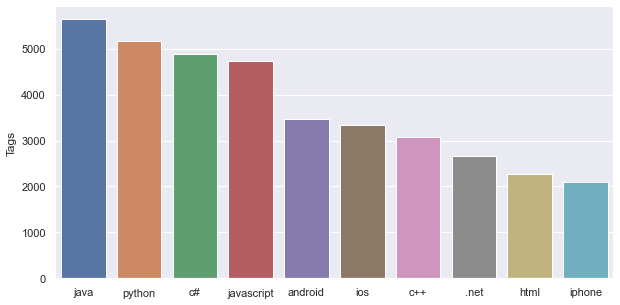

In [34]:
import matplotlib.pylab as plt
tags = pd.DataFrame()
tags['Tags'] = tag_bank
# for legend text
plt.figure(figsize = (10,5))

sns.barplot(tags['Tags'].value_counts().head(10).index,\
            tags['Tags'].value_counts().head(10))

top_ten = tags['Tags'].value_counts().head(10).index
top_ten_tags=[]
for i in range(len(top_ten)):
    top_ten_tags.append(top_ten[i])

In [10]:
tags['Tags'].value_counts().head(10).sum()

37339

In [11]:
#Création des data que nous utiliserons pour créer notre modèle supervisé
data_to_train = [] #--> X
target_to_train = [] #--> y
counter = 0
for tag in Tags:
    for i in tag:
        if i in top_ten_tags:            
            data_to_train.append(data.Body[counter])
            target_to_train.append(i)
            
            
    counter+=1

In [12]:
for tag in top_ten:
    print(tag)
    top_ten_tags.append(tag)

java
python
c#
javascript
android
ios
c++
.net
html
iphone


# Data preparation for text analysis

### Fonctions primaires 

In [4]:

def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

### Fonction déstinée à la création d'un "Bag of Word"

In [5]:
def question_to_words_BW(question):
    # On récupère le texte
    question_text = BeautifulSoup(question).get_text()
    
    #On ne garde que les caractères intéressants. 
    question = re.sub("[^a-zA-Z+#]"," ", question_text)
    
    # On tokenize nos questions en mots.
    words = question.lower().split()
    
    # On retire les mots clés plus courants avec peu de valeur ajoutée. 
    stops = set(stopwords.words('english'))
    meaningful_words = [w for w in words if not w in stops]
        
    # On lemmatize les mots
    meaningful_words = lemma_fct(meaningful_words)
    
    #On retourne une liste comprenant les mots ainsi récupérés. 
    return(" ".join( meaningful_words))

### Fonctions déstinée à la création du modèle Word2vec. 

In [6]:
def sentence_to_wordlist(sentence, remove_stopwords=False, remove_ponctuation=False,lemmatize = False):

    # 1. Remove HTML
    sentence = BeautifulSoup(sentence).get_text()
    sentence = re.sub("[^a-zA-Z+#]"," ", sentence)
    # 1. Tokenization des phrases en liste de mots. 
    words = sentence.split()    
    # 2. Lemmatisation des listes de mots(en option)
    if lemmatize:
        words = lemma_fct(words)
    
    # 3. Gestion des stopWords (en option)
    if remove_stopwords:
        stops = set(stopwords.words('english'))
        words = [w for w in words if not w in stops]
        
    # 4. Gestion de la ponctuation (en option)
    if remove_ponctuation:
        ponct = ['[', ']', ',', '.', ':', '?', '(', ')','\'','\"','`']
        words = [w for w in words if not w in ponct]
    
    # 5. Return a list of words
    return(words)

In [7]:
def question_to_sentences(question, tokenizer):
    # Function to split a question into parsed sentences. Returns a 
    # list of sentences, where each sentence is a list of words
    
    question = BeautifulSoup(question).get_text()
    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(question.strip())
    # 2. Loop over each sentence
    sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Otherwise, call review_to_wordlist to get a list of words
            sentences.append(sentence_to_wordlist(raw_sentence, remove_stopwords=False,\
                                                  remove_ponctuation=False, lemmatize=False))
    #
    # Return the list of sentences (each sentence is a list of words,
    # so this returns a list of lists
    return sentences

In [8]:
#tokenizer qui décompose en phrases via la ponctuation= punkt
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

# BAG Of WORDS

### Préprocessing

In [15]:
questions_cleared = []
for question in data.Body:
        cleared_question = question_to_words_BW(question)
        questions_cleared.append(cleared_question)
        
# On créé le vectorizer qui va vectorizer les mots de nos questions. 
#vectorizer = CountVectorizer(analyzer = "word", max_features = 5000) 
vectorizer = TfidfVectorizer(analyzer = "word", max_features = 5000)


# On fit notre vectorizer avec nos questions. 
questions_features = vectorizer.fit_transform(questions_cleared)
#questions_features = questions_features.toarray()

### Modèle de prédiction

In [16]:
from sklearn.decomposition import LatentDirichletAllocation
n_topics = 20

lda = LatentDirichletAllocation(n_components = n_topics, max_iter = 5, learning_method='online',learning_offset=50.,random_state=0)

lda.fit(questions_features)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, n_components=20, random_state=0)

#### Ici, notre modèle nous renvoie un vecteur de la taille n_topics, avec pour chacun d'entre eux la probabilité d'appartencance de notre quetioni en input 

In [17]:
lda.transform(questions_features[1])

array([[0.59287029, 0.00142857, 0.00142857, 0.00142857, 0.00142857,
        0.00142857, 0.00142857, 0.00142857, 0.00142857, 0.00142857,
        0.23513446, 0.14770954, 0.00142857, 0.00142857, 0.00142857,
        0.00142857, 0.00142857, 0.00142857, 0.00142857, 0.00142857]])

### Affichage des topics trouvés par notre modèle.


In [18]:
def display_topics(model, feature_names, no_top_words):
    topic_list = pd.DataFrame()
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        topic_list[topic_idx] = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]

no_top_words = 5
display_topics(lda,vectorizer.get_feature_names(), 5)

Topic 0:
would use one question like
Topic 1:
file python lib import path
Topic 2:
server client connection web springframework
Topic 3:
id data name value key
Topic 4:
function event node component return
Topic 5:
self image view color width
Topic 6:
error app message log io
Topic 7:
android java org layout com
Topic 8:
list entity transaction collection nan
Topic 9:
memory byte size number time
Topic 10:
class public new string return
Topic 11:
project build version git dependency
Topic 12:
test html page document tag
Topic 13:
form date value input name
Topic 14:
var json div function data
Topic 15:
user model app password controller
Topic 16:
http com url request php
Topic 17:
like way want would using
Topic 18:
window file gem ruby application
Topic 19:
int std array type char


/Users/florentmargery/opt/anaconda3/envs/work_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [19]:
from __future__ import print_function
import pyLDAvis

import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda, questions_features, vectorizer)

/Users/florentmargery/opt/anaconda3/envs/work_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/florentmargery/opt/anaconda3/envs/work_env/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/florentmargery/opt/anaconda3/envs/work_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/florentmargery/opt/anaconda3/envs/work_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp mod

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.254884  0.043230       1        1  13.614822
17     0.230253  0.012921       2        1  11.972840
10     0.035649 -0.119768       3        1   7.224179
6      0.083802  0.123699       4        1   7.086800
3      0.058219 -0.121698       5        1   6.593590
15     0.077484  0.088931       6        1   5.561404
5     -0.075923 -0.151593       7        1   5.516265
1     -0.084880  0.169134       8        1   4.921483
18     0.004563  0.224346       9        1   4.620219
16    -0.114271  0.083916      10        1   4.464446
7     -0.265299 -0.017423      11        1   4.163723
19     0.114909 -0.179025      12        1   3.883156
9      0.101574  0.036603      13        1   3.087966
2     -0.117846  0.196465      14        1   3.063337
13    -0.140839 -0.136740      15        1   2.886328
12    -0.088266 -0.071443      16        1   2.601677
14    -0.195507 -0.139072      17        1   2.598424
4      0.106836 -0.159308      18        1   2.557272
11    -0.035226  0.172263      19        1   2.249269
8      0.049884 -0.055439      20        1   1.332800, topic_info=            Term          Freq         Total Category  logprob  loglift
152      android  18440.000000  18440.000000  Default  30.0000  30.0000
2321        java  18560.000000  18560.000000  Default  29.0000  29.0000
2041        http  16264.000000  16264.000000  Default  28.0000  28.0000
2496        list  10813.000000  10813.000000  Default  27.0000  27.0000
3444      public  17167.000000  17167.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
2874      nested    364.654397    739.883254  Topic20  -4.9812   3.6103
2288      iphone    472.808198   1801.683437  Topic20  -4.7214   2.9801
63           add    601.293736   9185.326559  Topic20  -4.4811   1.5916
251      article    367.552852   1594.380266  Topic20  -4.9733   2.8505
1174  dictionary    307.979710    967.217306  Topic20  -5.1501   3.1735

[1341 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
8         1  0.040420  able
8         2  0.656884  able
8         3  0.013473  able
8         4  0.077524  able
8         5  0.025911  able
...     ...       ...   ...
4971     13  0.994108    xy
4984     12  0.999170   ymm
4988     15  0.996854  yyyy
4994      6  0.995348  zone
4996      7  0.998054  zoom

[3860 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 18, 11, 7, 4, 16, 6, 2, 19, 17, 8, 20, 10, 3, 14, 13, 15, 5, 12, 9])

### Création de la Pipeline regroupant le préprocessing et le modèle LDA

In [20]:
# On créé le vectorizer qui va vectorizer les mots de nos questions. 

# Pour chaque question, on applique la fonction qui récupère les mots clés des questions posées. 
def clearing_questions(Body):
    # On créé une liste vide déstinée à receullir les mots de nos questions. 
    questions_cleared =[]
    for question in Body:
        cleared_question = question_to_words_BW(question)
        questions_cleared.append(cleared_question)
        
    return questions_cleared


In [21]:
from sklearn import datasets, preprocessing, model_selection, ensemble, pipeline
from sklearn.experimental import enable_hist_gradient_boosting

/Users/florentmargery/opt/anaconda3/envs/work_env/lib/python3.9/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [22]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import LatentDirichletAllocation
n_topics = 20

from sklearn.pipeline import Pipeline
transformer_1 = FunctionTransformer(clearing_questions)
"""
pipeline_BOW = Pipeline([
   ('transformer', transformer_1), ('vectorizer',CountVectorizer(analyzer = "word", max_features = 5000)),
   ('LDA',LatentDirichletAllocation(n_components = n_topics, max_iter = 5,\
                                                                     learning_method='online',learning_offset=50.,random_state=0))
])
"""
pipeline_BOW = Pipeline([
   ('transformer', transformer_1), ('vectorizer',TfidfVectorizer(analyzer = "word", max_features = 5000)),
   ('LDA',LatentDirichletAllocation(n_components = n_topics, max_iter = 5,\
                                                                     learning_method='online',learning_offset=50.,random_state=0))
])

In [ ]:
pipeline_BOW.fit(data.Body)

In [ ]:
def create_topic_list(model, feature_names, no_top_words):
    topic_list = pd.DataFrame()
    for topic_idx, topic in enumerate(model.components_):
        topic_list[topic_idx] = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
    return topic_list

def tag_generator(questions):
    for question in questions:
        new_document_topic = np.where(question == question.max())
        new_document_topic = int(new_document_topic[0])
        print('La répartition des proba d\'appartenance aux différents TOPICS est \n  ', question)
        print('Les tags suggérés pour ce document sont :  \n',topic_list.T.iloc[new_document_topic,:5])
    return topic_list.T.iloc[new_document_topic,:5].tolist()



In [ ]:
no_top_words = 5
topic_list = create_topic_list(pipeline_BOW['LDA'],pipeline_BOW['vectorizer'].get_feature_names_out(),no_top_words)

### Essai de la pipeline avant API

In [16]:
test_text = pipeline_BOW.transform([data.Body[10]])
tag_generator(test_text)

La répartition des proba d'appartenance aux différents TOPICS est 
   [0.08098836 0.0085541  0.0085541  0.0085541  0.0085541  0.0085541
 0.0085541  0.0085541  0.0085541  0.0085541  0.0085541  0.0085541
 0.0085541  0.0085541  0.0085541  0.10318764 0.0085541  0.67040431
 0.0085541  0.0085541 ]
Les tags suggérés pour ce document sont :  
 0    would
1      use
2     like
3      one
4    using
Name: 17, dtype: object


['would', 'use', 'like', 'one', 'using']

# API Tf-Idf

In [18]:
from fast_dash import FastDash
from fast_dash.Components import Text

# Step 1: Define your model inference
def text_to_text_function(question):
    
    result = pipeline_BOW.transform([question])
    result = tag_generator(result)
    
    return result

# Step 2: Specify the input and output components
app = FastDash(callback_fn=text_to_text_function, 
                inputs=Text, 
                outputs=Text, 
                title='Unsupervised Question TAG Generator')

# Step 3: Run your app!
app.run()

# * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)

 * Serving Flask app 'fast_dash.fast_dash' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000 (Press CTRL+C to quit)
127.0.0.1 - - [19/Apr/2022 17:08:45] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [19/Apr/2022 17:08:46] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [19/Apr/2022 17:08:46] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [19/Apr/2022 17:08:46] "GET /assets/favicon.ico?m=1649961764.648881 HTTP/1.1" 200 -
127.0.0.1 - - [19/Apr/2022 17:08:46] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [19/Apr/2022 17:08:48] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [19/Apr/2022 17:08:48] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [19/Apr/2022 17:08:48] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [19/Apr/2022 17:08:48] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [19/Apr/2022 17:08:49] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [19/Apr/2022 17:08:49] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [19/Apr/2022 17:08:49] "POST /_dash-up

127.0.0.1 - - [19/Apr/2022 17:09:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [19/Apr/2022 17:09:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [19/Apr/2022 17:09:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [19/Apr/2022 17:09:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [19/Apr/2022 17:09:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [19/Apr/2022 17:09:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [19/Apr/2022 17:09:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [19/Apr/2022 17:09:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [19/Apr/2022 17:09:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [19/Apr/2022 17:09:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [19/Apr/2022 17:09:13] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [19/Apr/2022 17:09:14] "POST /_dash-update-component HTTP/1.1" 200 -
127.

La répartition des proba d'appartenance aux différents TOPICS est 
   [0.01187696 0.01187696 0.01187696 0.01187696 0.01187696 0.01187696
 0.01187696 0.01187696 0.01187696 0.01187696 0.01187696 0.01187696
 0.77433777 0.01187696 0.01187696 0.01187696 0.01187697 0.01187696
 0.01187696 0.01187696]
Les tags suggérés pour ce document sont :  
 0       file
1    project
2    command
3      error
4        run
Name: 12, dtype: object


127.0.0.1 - - [19/Apr/2022 17:09:33] "GET /assets/favicon.ico?m=1649961764.648881 HTTP/1.1" 304 -
127.0.0.1 - - [19/Apr/2022 17:09:34] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [19/Apr/2022 17:09:34] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [19/Apr/2022 17:09:34] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [19/Apr/2022 17:09:34] "GET /assets/favicon.ico?m=1649961764.648881 HTTP/1.1" 304 -
127.0.0.1 - - [19/Apr/2022 17:09:34] "POST /_dash-update-component HTTP/1.1" 200 -


# WORD2VEC Model

In [ ]:
sentences = []
for question in data['Body']:
    sentences += (question_to_sentences(question,tokenizer))

In [ ]:
# Import the built-in logging module and configure it so that Word2Vec 
# creates nice output messages
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 10   # Minimum word count                        
num_workers = 5      # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
from gensim.models import word2vec
print ("Training model...")
model = word2vec.Word2Vec(sentences, workers=num_workers, \
            vector_size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)



## Embedding du modèle Word2Vec

In [ ]:
def makeFeatureVec(words, model, num_features):
    # Function to average all of the word vectors in a given
    # paragraph
    #
    # Pre-initialize an empty numpy array (for speed)
    featureVec = np.zeros((num_features,),dtype="float32")
    #
    nwords = 0
    # 
    # Index2word is a list that contains the names of the words in 
    # the model's vocabulary. Convert it to a set, for speed 
    index2word_set = set(model.wv.index_to_key)
    #
    # Loop over each word in the review and, if it is in the model's
    # vocaublary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1
            featureVec = np.add(featureVec,model.wv[word])
    # 
    
    # Divide the result by the number of words to get the average
    featureVec = np.divide(featureVec,nwords)
    return featureVec


def getAvgFeatureVecs(reviews, model, num_features):
    # Given a set of reviews (each one a list of words), calculate 
    # the average feature vector for each one and return a 2D numpy array 
    # 
    # Initialize a counter
    counter = 0
    # 
    # Preallocate a 2D numpy array, for speed
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")

    # 
    # Loop through the reviews
    for review in reviews:
       #
       # Print a status message every 1000th review
        if counter%1000. == 0.:
            print ("Review %d of %d" % (counter, len(reviews)))
       # 
       # Call the function (defined above) that makes average feature vectors
        reviewFeatureVecs[counter] = makeFeatureVec(review, model,num_features)
       #
       # Increment the counter
        counter = counter + 1
    return reviewFeatureVecs

In [ ]:
# ****************************************************************
# Calculate average feature vectors for training and testing sets,
# using the functions we defined above. Notice that we now use stop word
# removal.

clean_train_questions = []
# Ici, data_to_train a été défini dans la partie "Gestion des Tags". Cela correspond aux données avec 
# au moins 1 des 10 tags les plus récurents. C'est sur ces données que l'on va entrainer notre modèle supervisé. 
for question in data_to_train:
    clean_train_questions.append(sentence_to_wordlist( question, \
        remove_stopwords=True ))
    
print ("Creating average feature vecs for test questions")
trainDataVecs = getAvgFeatureVecs(clean_train_questions, model, num_features)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(trainDataVecs,target_to_train_encoded,test_size=0.3)

In [ ]:
from sklearn.datasets import load_iris
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


model_to_set = OneVsRestClassifier(SVC(kernel="poly"))

parameters = {
    "estimator__C": [0.1,1,10],
    "estimator__kernel": ["poly","rbf"],
    "estimator__degree":[1, 2, 3],
}

model_tunning = GridSearchCV(model_to_set, param_grid=parameters)

model_tunning.fit(X_train[0:5000], y_train[0:5000])

print (model_tunning.best_score_)
print (model_tunning.best_params_)


In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

#Avec Probas :
clf = OneVsRestClassifier(SVC(probability=True))
clf.fit(X_train[0:1000], y_train[0:1000])

#Sans Probas : 
#clf = OneVsRestClassifier(SVC(probability=False)).fit(X_train, y_train)

In [ ]:
x = np.sort(clf.predict_proba(X_train[0:1]))
x[x>0.1]

### Pipeline

### Créons une pipeline afin de faciliter la prédiction de notre notre modèle. 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
target_to_train_encoded = label_encoder.fit_transform(target_to_train)

X_train, X_test, y_train, y_test = train_test_split(data_to_train,target_to_train_encoded,test_size=0.3)

In [ ]:
len(target_to_train_encoded)

In [ ]:
def cleaning_question_W2V(data_to_train):
    
    clean_train_questions = []
    # Ici, data_to_train a été défini dans la partie "Gestion des Tags". Cela correspond aux données avec 
    # au moins 1 des 10 tags les plus récurents. C'est sur ces données que l'on va entrainer notre modèle supervisé. 
    for question in data_to_train:
        clean_train_questions.append(sentence_to_wordlist( question, \
            remove_stopwords=True ))
    
    print ("Creating average feature vecs for test questions")
    trainDataVecs = getAvgFeatureVecs(clean_train_questions, model, num_features)
    return trainDataVecs

# Création d'un transformeur, permettant d'intégrer notre fonction dans la pipeline. 

from sklearn.preprocessing import FunctionTransformer
transformer_2 = FunctionTransformer(cleaning_question_W2V)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

### Création de la pipeline 

In [ ]:
pipeline = Pipeline([
   ('transformer', transformer_2), ('clf',OneVsRestClassifier(SVC(probability=True))), 
])

In [ ]:
pipeline.fit(X_train, y_train)

### Prédiction du classifier

In [36]:
clean_test_questions = []
data_to_test = data.Body[12356:12359]
for question in data_to_test:
    clean_test_questions.append(sentence_to_wordlist( question, \
        remove_stopwords=True ))
    
print ("Creating average feature vecs for test questions")
testDataVecs = getAvgFeatureVecs(clean_test_questions, model, num_features)

prediction = clf.predict(testDataVecs)
prediction = label_encoder.inverse_transform(prediction)
proba = clf.predict_proba(testDataVecs)
for i in range(len(prediction)):
    print('le texte n°',i,'est : \n', BeautifulSoup(data_to_test.iloc[i]).get_text() )
    print('LA PREDICTION EST :' , prediction[i])
    print('VECTEUR DE PROBA', proba[i])

NameError: name 'sentence_to_wordlist' is not defined

### Optional : Clustering

In [ ]:
from sklearn.cluster import KMeans
import time

start = time.time() # Start time

# Set "k" (num_clusters) to be 1/5th of the vocabulary size, or an
# average of 5 words per cluster
word_vectors = model.wv.vectors
num_clusters = int(word_vectors.shape[0] / 5)

# Initalize a k-means object and use it to extract centroids
kmeans_clustering = KMeans(n_clusters = num_clusters)
idx = kmeans_clustering.fit_predict(word_vectors)

# Get the end time and print how long the process took
end = time.time()
elapsed = end - start
print ("Time taken for K Means clustering: ", elapsed, "seconds.")

In [ ]:
pipeline.predict_proba(X_train[200:201])[0]

In [ ]:
probas = pipeline.predict_proba(X_train[200:201])[0]
print(probas)

result = []
for idx, prob in enumerate(probas) : 
    if prob > 0.1:
        result.append(idx)
result = label_encoder.inverse_transform(result)
print(result)


In [ ]:
pipeline.predict(X_train[200:201])[-1]

In [ ]:
probas = pipeline.predict_proba(X_train[200:201])[0]
print(probas)

result = []
for idx, prob in enumerate(probas) : 
    if prob > 0.1:
        result.append(idx)
result = label_encoder.inverse_transform(result)
print(result)


In [ ]:
result_2 =[]
for idx,i in enumerate(result) : 
    result_2.append(i)
    result_2.append(probas[idx])
result_2

# API Word2Vec

In [ ]:
from fast_dash import FastDash
from fast_dash.Components import Text

# Step 1: Define your model inference
def text_to_text_function(question):
    result = []
    result_2  = []
    probas = []
    #result = pipeline.predict([question])
    #result = label_encoder.inverse_transform(result)[0]
    result_proba = pipeline.predict_proba([question])
    print(result_proba)
    for idx, prob in enumerate(result_proba[0]) : 
        if prob > 0.1:
            result.append(idx)
            probas.append(probas)
    print(result)
    result = label_encoder.inverse_transform(result)
    return result

# Step 2: Specify the input and output components
app = FastDash(callback_fn=text_to_text_function, 
                inputs=Text, 
                outputs=Text, 
                title='App title')

# Step 3: Run your app!
app.run()

# * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)

# API BagOfWords

In [ ]:
from fast_dash import FastDash
from fast_dash.Components import Text

# Step 1: Define your model inference
def text_to_text_function(question):
    
    result = pipeline_BOW.transform([question])
    
    
    return result

# Step 2: Specify the input and output components
app = FastDash(callback_fn=text_to_text_function, 
                inputs=Text, 
                outputs=Text, 
                title='Tag Generator')

# Step 3: Run your app!
app.run()

# * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)